<a href="https://colab.research.google.com/github/center4ml/Workshops/blob/2023_2/Day_2/40_PINN-PDE-inverse_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inverse Diffusion Problem with Physics-informed Neural Networks

This notebook follows example from torchphysics package:
https://github.com/boschresearch/torchphysics/blob/main/examples/pinn/inverse-heat-equation-D-function.ipynb

## Diffusion equation

### Diffusion Equation in 2 Dimensions

#### uniform diffusion coefficient

The diffusion equation in two dimensions can be expressed as:

$$
\frac{∂u}{∂t} = D \left( \frac{∂^2u}{∂x^2} + \frac{∂^2u}{∂y^2} \right)
$$

where:
-  $u(x,y,t)$ represents the concentration of the diffusing substance at position (x, y) and time t.
- $D$ is the diffusion coefficient. It represents the rate at which the substance diffuses.

The left-hand side, $\frac{∂u}{∂t}$, represents the rate of change of concentration with time.

The right-hand side of the equation models how the concentration changes in space, taking into account both the x and y directions.

To solve this equation, appropriate boundary and initial conditions must be specified. These conditions depend on the physical setup of the problem.

#### Non-uniform diffusion coefficient


When dealing with a non-uniform diffusion coefficient, the diffusion equation in two dimensions is modified to account for spatial variations in the diffusion coefficient, $D(x,y)$. This coefficient can change with position, reflecting variations in the material properties or the medium through which the substance diffuses.

The modified diffusion equation becomes:

$$
\frac{∂u}{∂t} = \frac{∂}{∂x} \left( D(x,y) \frac{∂u}{∂x} \right) + \frac{∂}{∂y} \left( D(x,y) \frac{∂u}{∂y} \right)
$$

where:
- $D(x,y)$ is the spatially varying diffusion coefficient.

### Heat Diffusion in 2 Dimensions

The concept of diffusion can also be applied to heat transfer. In this context, the diffusion equation is often referred to as the Heat Equation.

The heat equation in two dimensions is given by:

$$
\frac{∂T}{∂t} =  \frac{∂}{∂x} \left( \alpha \frac{∂T}{∂x}\right) + \frac{∂}{∂y} \left( \alpha \frac{∂R}{∂y}\right) = div(\alpha ∇T)
$$

where:
- $T(x,y,t)$ represents the temperature at position (x, y) and time t.
- $ \alpha(x,y) $ is the thermal diffusivity of the material, analogous to the diffusion coefficient in mass diffusion.
- $\nabla$ is gradient operator
- $div$ is divergence operator


Thermal diffusivity, $\alpha$ is a measure of how quickly heat diffuses through a material and is directly related to the material's properties:

$$
\alpha = \frac{k}{\rho c_p}
$$

where:
- $k$ is the thermal conductivity of the material, which measures the ability of a material to conduct heat.
- $\rho$ is the density (mass per unit volume) of the material.
- $c_p$ is the specific heat capacity of the material, which indicates the amount of heat required to raise the temperature of a unit mass of the material by one degree Celsius.

### Flux in Diffusion Processes



#### Flux in Substance Concentration

In the context of substance concentration, the term 'flux' refers to the rate at which a substance moves through a unit area. The flux, often denoted as $J$, can be described in the framework of Fick's laws of diffusion.

According to Fick's First Law, the flux of a diffusing substance is proportional to the negative gradient of concentration. It can be expressed as:

$$
J = -D \nabla u
$$

where:
- $J$ is the diffusion flux (amount of substance per unit area per unit time).
- $D$ is the diffusion coefficient.
- $\nabla u$ is the concentration gradient.

This law implies that the substance moves from regions of higher concentration to regions of lower concentration, with a flux magnitude dependent on the concentration gradient and the diffusion coefficient.

#### Flux in Heat Diffusion

In heat diffusion, the concept of flux represents the rate at which heat energy moves through a unit area. This is often termed as 'heat flux', and is crucial in understanding heat transfer processes.

The heat flux, denoted by $q$, in a medium is given by Fourier's Law of heat conduction:

$$
q = -k \nabla T
$$

where:
- $q$ is the heat flux (amount of heat energy per unit area per unit time).
- $k$ is the thermal conductivity of the material.
- $\nabla T$ is the temperature gradient.

In this case, heat flux describes the flow of heat energy from regions of higher temperature to regions of lower temperature. The rate of heat transfer is proportional to the temperature gradient and the material's ability to conduct heat (thermal conductivity).

#### Flux summary




1. **Direction of Flux**: Both in substance diffusion and heat diffusion, the flux moves from higher to lower concentrations (substance) or temperatures (heat).
2. **Proportional Factors**: The magnitude of flux is directly proportional to the gradient (of concentration or temperature) and the respective diffusion coefficient or thermal conductivity.

### Gradient and divergence operators

#### Gradient

The gradient is a vector operator that represents the rate and direction of the most rapid increase of a scalar field. In essence, the gradient points in the direction of the greatest rate of increase of the function, and its magnitude is the rate of increase in that direction.

$$
\nabla u(x,y) = \begin{bmatrix} \frac{\partial u}{\partial x} \\ \frac{\partial u}{\partial y} \end{bmatrix}
$$

where $∇$ is gradient operator

In the context of physics, when considering functions of space and time, the gradient usually refers to the spatial derivatives only.

#### Divergence

Divergence is a vector operator that measures the magnitude of a vector field's source or sink at a given point. In simple terms, it represents how much the vector field is 'diverging' from a particular point.

For a vector field $\mathbf{v} = \begin{bmatrix} v_x \\ v_y \end{bmatrix}$ in two dimensions, the divergence is given by:

$$
\text{div} \begin{bmatrix} v_x \\ v_y \end{bmatrix} = \frac{\partial v_x}{\partial x} + \frac{\partial v_y}{\partial y}
$$

where $\text{div} $ is divergence operator


## Problem Statement

In this notebook, we aim to approximate the diffusion coefficient $D(x, y)$ and the concentration function $u(x, y, t)$ using neural networks. These approximations are denoted as $\hat{D}_{\theta_1}(x, y)$ and $\hat{u}_{\theta_2}(x, y, t)$, respectively. They are trained based on a set of observations $\{u_i(x_i, y_i, t_i)\}$.

Our goal is to train these neural networks so that the approximated functions $\hat{D}_{\theta_1}(x, y)$ and $\hat{u}_{\theta_2}(x, y, t)$ minimize two types of loss: the deviation from the observed data (represented by $\mathcal{L}_{data}$ loss) and the deviation from the diffusion equation for a non-uniform diffusion coefficient (represented by $\mathcal{L}_{physics}$ loss).

The data loss ($\mathcal{L}_{data}$) is defined as:

$$
\mathcal{L}_{data} = \sum_i \left| u_i - \hat{u}_{\theta_2}(x_i, y_i, t_i) \right|^2
$$

The physics-informed loss ($\mathcal{L}_{physics}$) is expressed as an integral over the spatial and temporal domain, ensuring the adherence to the diffusion equation:

$$
\mathcal{L}_{physics} = \int \left| \frac{∂u}{∂t} - \nabla \cdot \left( D(x,y) \nabla u \right) \right|^2 dxdydt
$$

where $\nabla \cdot \left( D(x,y) \nabla u \right)$ represents the divergence of the product of the spatially varying diffusion coefficient and the gradient of $u$.


[](https://drive.google.com/uc?export=1KO_jLsU5_Jgpm9VO7wDSnDMOG57Yx0_h)

![](https://drive.google.com/uc?export=view&id=1KO_jLsU5_Jgpm9VO7wDSnDMOG57Yx0_h)


## Imports

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
from copy import deepcopy

## Architectures

In [ ]:
def _construct_FC_layers(hidden, input_dim, output_dim, activations):
    """Constructs the layer structure for a fully connected neural network.
    """
    layers = []
    layers.append(torch.nn.Linear(input_dim, hidden[0]))
    layers.append(activations)
    for i in range(len(hidden)-1):
        layers.append(torch.nn.Linear(hidden[i], hidden[i+1]))
        layers.append(activations)
    layers.append(torch.nn.Linear(hidden[-1], output_dim))
    return layers

def normalize(x, x_min, x_max):
    """scales [x_min, x_max] to [-1, 1] range"""
    return 2.*(x-x_min)/(x_max-x_min) -1

class FCN(torch.nn.Module):
    """A simple fully connected neural network.

    Parameters
    ----------
    input_dim : int
        The space of the points the can be put into this model.
    output_dim : int
        The space of the points returned by this model.
    hidden : list or tuple
        The number and size of the hidden layers of the neural network.
        The lenght of the list/tuple will be equal to the number
        of hidden layers, while the i-th entry will determine the number
        of neurons of each layer.
        E.g hidden = (10, 5) -> 2 layers, with 10 and 5 neurons.
    activations : torch.nn, optional
        The activation functions of this network. Deafult is nn.Tanh().
    """
    def __init__(self,
                 input_dim,
                 output_dim,
                 hidden=(20,20,20),
                 activations=torch.nn.Tanh(), # Not ReLU!
                 normalize=False,
                 x_max = None,
                 x_min = None
                ):
        super().__init__()

        self.normalize = normalize
        if self.normalize:
            self.register_buffer('x_max', torch.tensor(x_max).float())
            self.register_buffer('x_min', torch.tensor(x_min).float())
        layers = _construct_FC_layers(hidden=hidden, input_dim=input_dim,
                                      output_dim=output_dim,
                                      activations=activations)

        self.sequential = torch.nn.Sequential(*layers)

    def forward(self, *x):
        x = torch.cat(x, dim=-1) # concatenate along last dimension
        if self.normalize:
            x = normalize(x, self.x_min, self.x_max)
        return self.sequential(x)

### Create and test networks

In [ ]:
# domain
w, h = 10, 10
t_0, t_end = 0, 5

In [ ]:
# network to estimate u(x,y,t)
model_u = FCN(3, 1, hidden=(80,80,50,50), normalize=True, x_min=[0,0,t_0], x_max=[w, h, t_end])
# network to estimate D(x,y)
model_D = FCN(2, 1, hidden=(80,80,50,50), normalize=True, x_min=[0,0], x_max=[w, h])


In [ ]:
# try networks:
batch_size = 16
xyt = torch.rand(batch_size,3)
print(model_u(xyt).shape) # expected (batch_size, 1)
print(model_D(xyt[:,:2]).shape) # expected (batch_size, 1)

torch.Size([16, 1])
torch.Size([16, 1])


#### buffers
What buffers are?

In [ ]:
# buffers are stored in model state (see `x_min` and `x_max`)
model_D.state_dict().keys()

odict_keys(['x_max', 'x_min', 'sequential.0.weight', 'sequential.0.bias', 'sequential.2.weight', 'sequential.2.bias', 'sequential.4.weight', 'sequential.4.bias', 'sequential.6.weight', 'sequential.6.bias', 'sequential.8.weight', 'sequential.8.bias'])

In [ ]:
# they are tensors
model_D.x_max

tensor([10., 10.])

In [ ]:
# buffers are transfered to device in the same way as parameters
model_D.cuda();
model_D.x_max.device

device(type='cuda', index=0)

In [ ]:
model_D.cpu();

## Data

download data from torchphysics example

In [ ]:
!mkdir data
! wget -O data/heat-eq-inverse-data.npy https://github.com/boschresearch/torchphysics/raw/989baa9d6e789ebebb07d1e09df26627f942ab13/examples/pinn/data/heat-eq-inverse-data.npy
# https://github.com/boschresearch/torchphysics/raw/main/examples/pinn/data/heat-eq-inverse-data.npy

mkdir: cannot create directory ‘data’: File exists
--2023-11-29 15:22:21--  https://github.com/boschresearch/torchphysics/raw/989baa9d6e789ebebb07d1e09df26627f942ab13/examples/pinn/data/heat-eq-inverse-data.npy
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/boschresearch/torchphysics/989baa9d6e789ebebb07d1e09df26627f942ab13/examples/pinn/data/heat-eq-inverse-data.npy [following]
--2023-11-29 15:22:21--  https://raw.githubusercontent.com/boschresearch/torchphysics/989baa9d6e789ebebb07d1e09df26627f942ab13/examples/pinn/data/heat-eq-inverse-data.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 

In [ ]:
solution_data_all = np.load('data/heat-eq-inverse-data.npy')
print(len(solution_data_all), f'datapoints in t, x, y, u format. Shape: {solution_data_all.shape}')

85731 datapoints in t, x, y, u format. Shape: (85731, 4)


In [ ]:
# subsample data
num_of_data = 30_000
solution_data = solution_data_all[np.random.choice(len(solution_data_all), num_of_data, replace=False), :].astype(np.float32)

In [ ]:
xyt_data = torch.tensor(solution_data[:,(1,2,0)])
u_data = torch.tensor(solution_data[:,3:4])

In [ ]:
xyt_data.shape, u_data.shape

(torch.Size([30000, 3]), torch.Size([30000, 1]))

In [ ]:
# input_data.min(dim=0), input_data.max(dim=0)

### data loss

In [ ]:
data_loss_function = torch.nn.functional.mse_loss

Test data loss function:

In [ ]:
pred_u = model_u(xyt_data)

In [ ]:
data_loss_function(pred_u, u_data)

tensor(780.2701, grad_fn=<MseLossBackward0>)

## Physics information

### gradient implementations and testing

In [ ]:
# from https://github.com/boschresearch/torchphysics/blob/main/src/torchphysics/utils/differentialoperators.py
def grad(model_out, *derivative_variable):
    '''Computes the gradient of a network with respect to the given variable.
    Parameters
    ----------
    model_out : torch.tensor
        The (scalar) output tensor of the neural network
    derivative_variable : torch.tensor
        The input tensor of the variables in which respect the derivatives have to
        be computed
    Returns
    ----------
    torch.tensor
        A Tensor, where every row contains the values of the the first
        derivatives (gradient) w.r.t the row of the input variable.
    '''
    grad = []
    for vari in derivative_variable:
        new_grad = torch.autograd.grad(model_out.sum(), vari,
                                       create_graph=True, allow_unused=True)[0]
        grad.append(new_grad)
    return torch.column_stack(grad)

def div(model_out, *derivative_variable):
    '''Computes the divergence of a network with respect to the given variable.
    Only for vector valued inputs, for matices use the function matrix_div.
    Parameters
    ----------
    model_out : torch.tensor
        The output tensor of the neural network
    derivative_variable : torch.tensor
        The input tensor of the variables in which respect the derivatives have to
        be computed. Have to be in a consistent ordering, if for example the output
        is u = (u_x, u_y) than the variables has to passed in the order (x, y)
    Returns
    ----------
    torch.tensor
        A Tensor, where every row contains the values of the divergence
        of the model w.r.t the row of the input variable.
    '''
    divergence = torch.zeros((*derivative_variable[0].shape[:-1], 1),
                             device=derivative_variable[0].device)
    var_dim = 0
    for vari in derivative_variable:
        for i in range(vari.shape[-1]):
            Du = torch.autograd.grad(model_out.narrow(-1, var_dim + i, 1).sum(),
                                     vari, create_graph=True, allow_unused=True)[0]
            divergence = divergence + Du.narrow(-1, i, 1)
        var_dim += i + 1
    return divergence

In [ ]:
# # show grad and div working
def f(x, y):
    return x**3 + 0.5*y**2

def f2(xy):
  return

# let's take x=y=1 and z=f(x, y)
#grad(z, x) should give 3*1**2=3 and grad(z, y) 0.5*2=1
# div(z, x, y) should give 3+1 =4

x = torch.tensor([[1.0]], requires_grad=True)
y = torch.tensor([[1.0]], requires_grad=True)
xy = torch.tensor([[1.0, 1.0]], requires_grad=True)

z = f(x, y)
print('df/dx', grad(z, x), 'expected 3*x^2=3*1^2=3')
print('df/dy', grad(z, y))
print('div f2', div(xy**2, xy))



df/dx tensor([[3.]], grad_fn=<CatBackward0>) expected 3*x^2=3*1^2=3
df/dy tensor([[1.]], grad_fn=<CatBackward0>)
div f2 tensor([[4.]], grad_fn=<AddBackward0>)


#### simple setting

Example:

$${u}(x,y) = \begin{bmatrix}x^2\\
y^3
\end{bmatrix}$$

$$ \nabla \cdot u = 2 x + 3 y^2 $$

In [ ]:
# try div operator
X, Y = np.meshgrid(np.linspace(-1,1,11), np.linspace(-1,1,11))

xy = torch.tensor(np.stack((X,Y), axis=2).reshape(-1,2), requires_grad=True)


In [ ]:
# uy = torch.cos(x) + 1/y

In [ ]:
def u(xy):
  return torch.stack((xy[:,0]**2, xy[:,1]**3), dim=1)

def div_u(xy):
  return 2*xy[:,0] + 3*xy[:,1]**2

div_numeric = div(u(xy), xy)
div_symbolic = div_u(xy.detach())

In [ ]:
U_x, U_y = u(xy.detach()).numpy().T
U_x = U_x.reshape((11,11))
U_y = U_y.reshape((11,11))

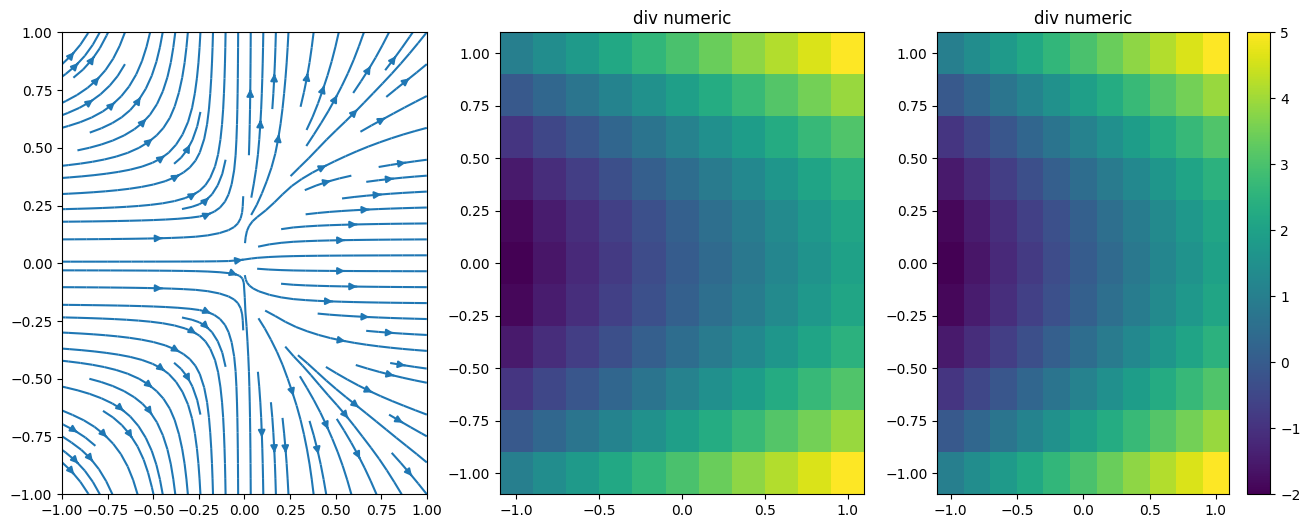

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(16,6))
axs[0].streamplot(X, Y, U_x, U_y)
axs[1].pcolormesh(X, Y, div_numeric.detach().numpy().reshape(11,11), vmin=-2, vmax=5)
axs[1].set_title('div numeric')
colorbar = axs[2].pcolormesh(X, Y, div_symbolic.detach().numpy().reshape(11,11), vmin=-2, vmax=5)
axs[2].set_title('div numeric')
fig.colorbar(colorbar, ax=axs[2])


#### our setting

physics informed loss guide the solution toward satisfying the equation:

$$
\frac{∂u}{∂t} = \frac{∂}{∂x} \left( D(x,y) \frac{∂u}{∂x} \right) + \frac{∂}{∂y} \left( D(x,y) \frac{∂u}{∂y} \right) = ∇⋅(D∇u)
$$

In [ ]:
def heat_residual(u, x, t, D):
    return div(D*grad(u, x), x) - grad(u, t)

In [ ]:
xy_batch = xyt_data[:,:2].clone().requires_grad_(True)
t_batch = xyt_data[:,2:].clone().requires_grad_(True)
u_batch = u_data.clone().requires_grad_(True)

# poits at which physics condition is evaluated
# batch_size_collocation = 15000

u_pred = model_u(xy_batch, t_batch)
d_pred = model_D(xy_batch)

residual = heat_residual(u_pred, xy_batch,t_batch, d_pred)
print(residual.shape)


torch.Size([30000, 1])


Physics-informed loss:

In [ ]:
torch.mean(torch.abs(residual)**2)

tensor(9.8531e-05, grad_fn=<MeanBackward0>)

### Physics-informed loss

Collocation points are sampled

In [ ]:
def uniform_sampler(batch_size, x_min, x_max):
    """
    Samples uniformly from the given ranges for each dimension.

    Parameters:
    - batch_size (int): Number of samples to generate.
    - x_min (list or torch.Tensor): Lower bounds for each dimension.
    - x_max (list or torch.Tensor): Upper bounds for each dimension.

    Returns:
    - x (torch.Tensor): Tensor of shape (batch_size, len(x_min)) containing the samples.
    """
    x_min = torch.tensor(x_min).float()
    x_max = torch.tensor(x_max).float()

    # Generate uniform samples in the range [0, 1]
    rand_samples = torch.rand(batch_size, len(x_min))

    # Scale and shift the samples to the desired range
    samples = x_min + (x_max - x_min) * rand_samples

    return samples

In [ ]:
def physics_loss_function(residual, eps=1e-6):
    mask = torch.abs(residual) > eps
    if not torch.any(mask):
        return torch.tensor(0, dtype=residual.dtype)

    return torch.mean(residual[mask]**2)

Physics informed loss is calculated at so called "collocation points". These points are usually resampled at every step

In [ ]:
batch_size_collocation = 15_000
data_weight = 1.
physics_weight = 1. # 100.

In [ ]:

pred_u = model_u(xyt_data)
loss_data = data_weight*data_loss_function(pred_u, u_data)
loss_data.backward()

xy_sample = uniform_sampler(batch_size_collocation, [0, 0], [w, h])
t_sample = uniform_sampler(batch_size_collocation, [t_0], [t_end])
xy_sample.requires_grad = True
t_sample.requires_grad = True

u_pred = model_u(xy_sample, t_sample)
d_pred = model_D(xy_sample)

physics_residual = heat_residual(u_pred, xy_sample,t_sample, d_pred)
physics_loss = physics_loss_function(physics_residual)
physics_loss.backward()



## Training

In [ ]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# network to estimate u(x,y,t)
model_u = FCN(3, 1, hidden=(80,80,50,50), normalize=True, x_min=[0,0,t_0], x_max=[w, h, t_end])
# network to estimate D(x,y)
model_D = FCN(2, 1, hidden=(80,80,50,50), normalize=True, x_min=[0,0], x_max=[w, h])


In [ ]:
batch_size_collocation = 45_000
data_weight = 1.
physics_weight = 1.
num_epochs_adam = 6_000
parameters = [*model_u.parameters(), *model_D.parameters()]
optimizer = torch.optim.Adam(parameters, lr=1e-3)

model_u.train().to(device)
model_D.train().to(device)
u_data = u_data.to(device)
xyt_data = xyt_data.to(device)

history = []
for epoch in range(num_epochs_adam):

    optimizer.zero_grad()  # Clear gradients before next loss is computed

    # data loss computation
    pred_u = model_u(xyt_data)
    data_loss = data_loss_function(pred_u, u_data)
    data_loss_weighted = data_weight * data_loss

    # sample data for physics informed loss
    xy_sample = uniform_sampler(batch_size_collocation, [0, 0], [w, h]).to(device)
    t_sample = uniform_sampler(batch_size_collocation, [t_0], [t_end]).to(device)
    xy_sample.requires_grad = True
    t_sample.requires_grad = True

    # physics informed loss computation
    u_pred = model_u(xy_sample, t_sample)
    d_pred = model_D(xy_sample)

    physics_residual = heat_residual(u_pred, xy_sample,t_sample, d_pred)
    physics_loss = physics_loss_function(physics_residual)
    physics_loss_weighted = physics_weight * physics_loss

    loss = data_loss_weighted + physics_loss_weighted
    loss.backward()
    torch.nn.utils.clip_grad_norm_(parameters, 10.) # improves training stability

    losses = {
        'data': data_loss.item(),
        'physics': physics_loss.item(),
        'data_weighted': data_loss_weighted.item(),
        'physics_weighted': physics_loss_weighted.item(),
        'weighted_sum': loss.item()
        }

    optimizer.step()  # Update weights
    # optimizer.zero_grad()  # Clear gradients

    history.append(losses)
    if epoch % 100 == 0:
        print(epoch, losses)


0 {'data': 778.3961181640625, 'physics': 0.0002991419460158795, 'data_weighted': 778.3961181640625, 'physics_weighted': 0.0002991419460158795, 'weighted_sum': 778.3964233398438}
100 {'data': 496.66168212890625, 'physics': 1.9896606318070553e-05, 'data_weighted': 496.66168212890625, 'physics_weighted': 1.9896606318070553e-05, 'weighted_sum': 496.6617126464844}
200 {'data': 378.5328674316406, 'physics': 0.08370410650968552, 'data_weighted': 378.5328674316406, 'physics_weighted': 0.08370410650968552, 'weighted_sum': 378.6165771484375}
300 {'data': 279.80096435546875, 'physics': 0.4037603437900543, 'data_weighted': 279.80096435546875, 'physics_weighted': 0.4037603437900543, 'weighted_sum': 280.2047119140625}
400 {'data': 188.7902374267578, 'physics': 1.2501214742660522, 'data_weighted': 188.7902374267578, 'physics_weighted': 1.2501214742660522, 'weighted_sum': 190.0403594970703}
500 {'data': 129.61656188964844, 'physics': 1.9696825742721558, 'data_weighted': 129.61656188964844, 'physics_we

In [ ]:
history = pd.DataFrame(history)
history.head()

,data,physics,data_weighted,physics_weighted,weighted_sum
0,778.396118,0.000299,778.396118,0.000299,778.396423
1,774.824524,0.000117,774.824524,0.000117,774.824646
2,771.386292,0.000028,771.386292,0.000028,771.386292
3,767.989868,0.000017,767.989868,0.000017,767.989868
4,764.568787,0.000072,764.568787,0.000072,764.568848


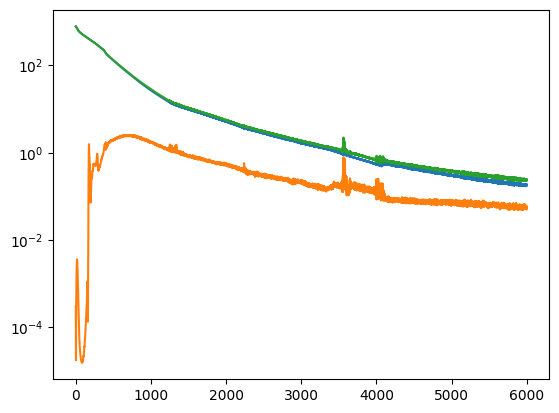

In [ ]:
plt.semilogy(history['data'])
plt.semilogy(history['physics'])
plt.semilogy(history['weighted_sum'])

L-BFGS optimizer, unlike Adam, requires static data and callable closure function. Closure does not take any parameter and return the loss value which is to be minimized.


Limited-memory BFGS (L-BFGS) is an optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory. L-BFGS uses an estimate of the inverse Hessian matrix to steer its search [wikipedia](https://en.wikipedia.org/wiki/Limited-memory_BFGS)

In [ ]:
# make backup in case the fine-tuning go wrong
model_u_state = deepcopy(model_u.state_dict())
model_D_state = deepcopy(model_D.state_dict())

In [ ]:
# # load the backup if needed
# model_u.load_state_dict(model_u_state)
# model_D.load_state_dict(model_D_state)

<All keys matched successfully>

In [ ]:
num_epochs_lbfgs = 3_000

optimizer = torch.optim.LBFGS(
    parameters,
    lr=0.5, max_iter=num_epochs_lbfgs, history_size=100
)

# static data
xy_sample = uniform_sampler(batch_size_collocation, [0, 0], [w, h]).to(device)
t_sample = uniform_sampler(batch_size_collocation, [t_0], [t_end]).to(device)

history_finetuning = []
def closure():
    optimizer.zero_grad()  # Clear gradients before next loss is computed

    # data loss computation
    pred_u = model_u(xyt_data)
    data_loss = data_loss_function(pred_u, u_data)
    data_loss_weighted = data_weight * data_loss

    # sample data for physics informed loss
    xy_sample = uniform_sampler(batch_size_collocation, [0, 0], [w, h]).to(device)
    t_sample = uniform_sampler(batch_size_collocation, [t_0], [t_end]).to(device)
    xy_sample.requires_grad = True
    t_sample.requires_grad = True

    # physics informed loss computation
    u_pred = model_u(xy_sample, t_sample)
    d_pred = model_D(xy_sample)

    physics_residual = heat_residual(u_pred, xy_sample,t_sample, d_pred)
    physics_loss = physics_loss_function(physics_residual)
    physics_loss_weighted = physics_weight * physics_loss

    loss = data_loss + physics_loss
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(parameters, 10.)

    losses = {
        'data': data_loss.item(),
        'physics': physics_loss.item(),
        'data_weighted': data_loss_weighted.item(),
        'physics_weighted': physics_loss_weighted.item(),
        'weighted_sum': loss.item()
        }
    history_finetuning.append(losses)
    if (len(history_finetuning) % 100) == 0:
      print(len(history_finetuning), losses)
    return loss

optimizer.step(closure)  # Update weights


100 {'data': 0.029076343402266502, 'physics': 0.028590679168701172, 'data_weighted': 0.029076343402266502, 'physics_weighted': 0.028590679168701172, 'weighted_sum': 0.057667024433612823}
200 {'data': 0.017515653744339943, 'physics': 0.014828438870608807, 'data_weighted': 0.017515653744339943, 'physics_weighted': 0.014828438870608807, 'weighted_sum': 0.032344091683626175}
300 {'data': 0.013992034830152988, 'physics': 0.010053596459329128, 'data_weighted': 0.013992034830152988, 'physics_weighted': 0.010053596459329128, 'weighted_sum': 0.024045631289482117}
400 {'data': 0.01148148626089096, 'physics': 0.008050155825912952, 'data_weighted': 0.01148148626089096, 'physics_weighted': 0.008050155825912952, 'weighted_sum': 0.01953164115548134}
500 {'data': 0.009562842547893524, 'physics': 0.006759197451174259, 'data_weighted': 0.009562842547893524, 'physics_weighted': 0.006759197451174259, 'weighted_sum': 0.01632203906774521}
600 {'data': 0.008506678976118565, 'physics': 0.005766602698713541, '

tensor(0.2219, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
history_finetuning = pd.DataFrame(history_finetuning)

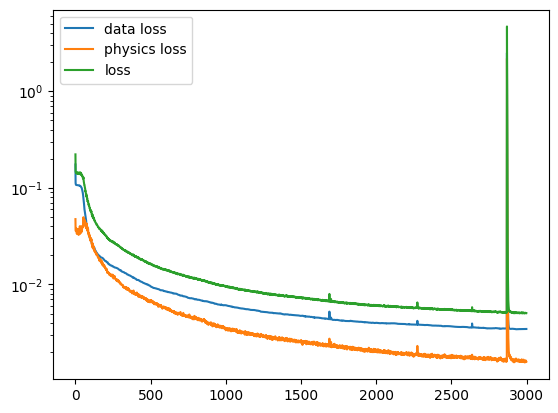

In [ ]:
plt.semilogy(history_finetuning['data'], label='data loss')
plt.semilogy(history_finetuning['physics'], label='physics loss')
plt.semilogy(history_finetuning['weighted_sum'], label='loss')
plt.legend()

## Visualize $D(x,y)$

In [ ]:
vis_res = 101
X, Y = np.meshgrid(np.linspace(0, w, vis_res), np.linspace(0, h, vis_res))

In [ ]:
def exact(x, y):
    return 5*np.exp(-1/20.0 * ((x - 3)**2 + (y - 3)**2))


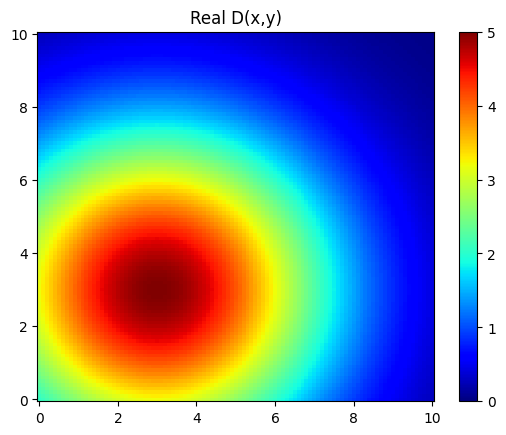

In [ ]:
plt.pcolormesh(X, Y, exact(X,Y), cmap='jet', vmin=0, vmax=5)
plt.colorbar()
plt.title('Real D(x,y)');

In [ ]:
# calculate approximated D
xy = torch.cat((torch.tensor(X.reshape(-1,1)), torch.tensor(Y.reshape(-1,1))), dim=1).float().to(device)
with torch.no_grad():
    d_pred = model_D(xy).cpu().numpy().reshape(vis_res, vis_res)

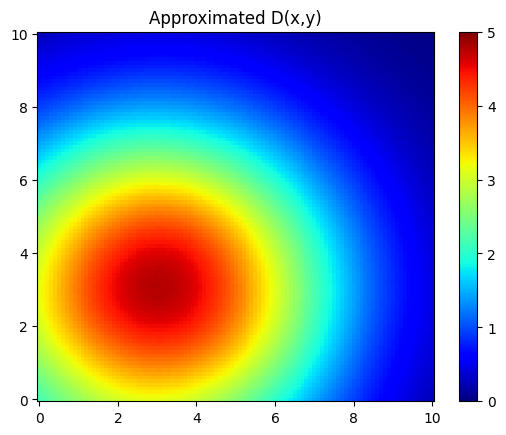

In [ ]:
plt.pcolormesh(X, Y, d_pred, cmap='jet', vmin=0, vmax=5)
plt.colorbar()
plt.title('Approximated D(x,y)');

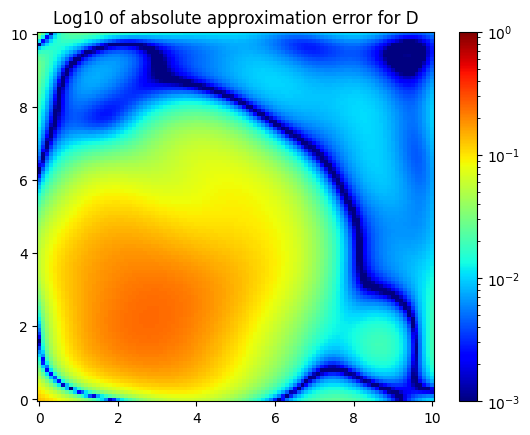

In [ ]:
# plt.pcolormesh(X, Y, d_pred-exact(X,Y), cmap='jet', vmin=-1, vmax=1)
plt.pcolormesh(X, Y, abs(d_pred-exact(X,Y)), cmap='jet', norm=colors.LogNorm(vmin=1e-3, vmax=1))

plt.colorbar()
plt.title('Log10 of absolute approximation error for D');

### Visualize $u(x,y,t)$

In [ ]:
X, Y = np.meshgrid(np.arange(0, 10.1, 0.25), np.arange(0, 10.1, 0.25))
xy_batch = torch.stack(
    (
      torch.tensor(X.flatten()),
      torch.tensor(Y.flatten()),
    ),
    dim=1
    ).float().unsqueeze(0)


In [ ]:
# data are given in a weird order, let's find it for t=0 and apply later for visualization
data_t0 = solution_data_all[solution_data_all[:,0]==0]
data_order = np.argsort(data_t0[:,1]*10000 + data_t0[:,2])

In [ ]:
t_snapshots = np.unique(solution_data_all[:,0])[::10]
t_snapshots

array([0., 1., 2., 3., 4., 5.])

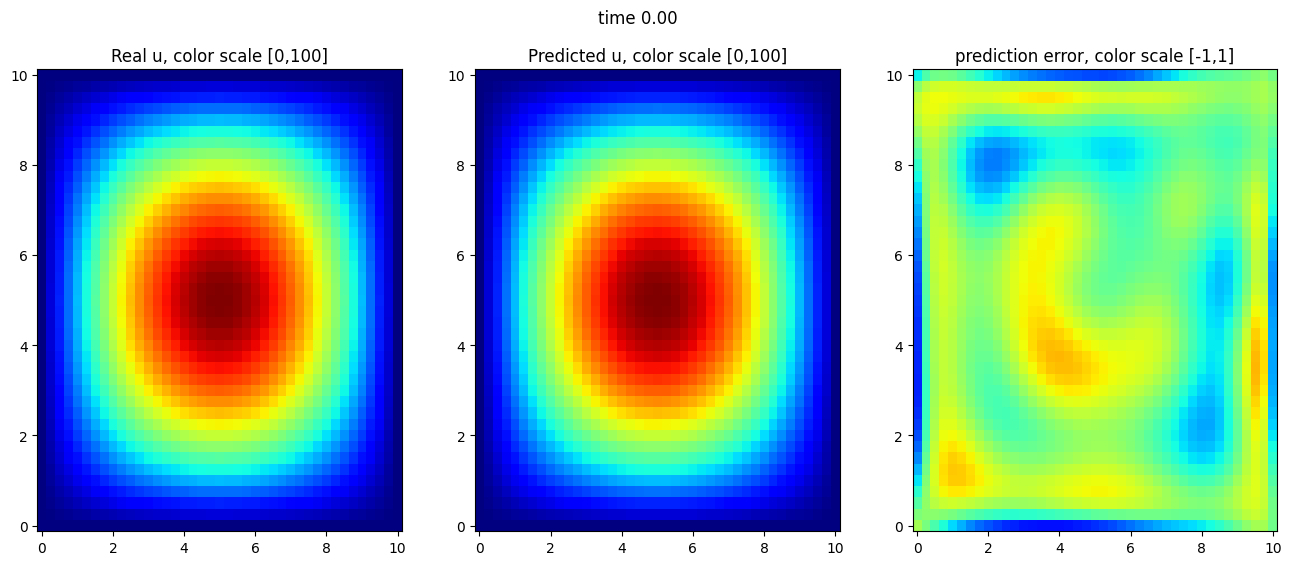

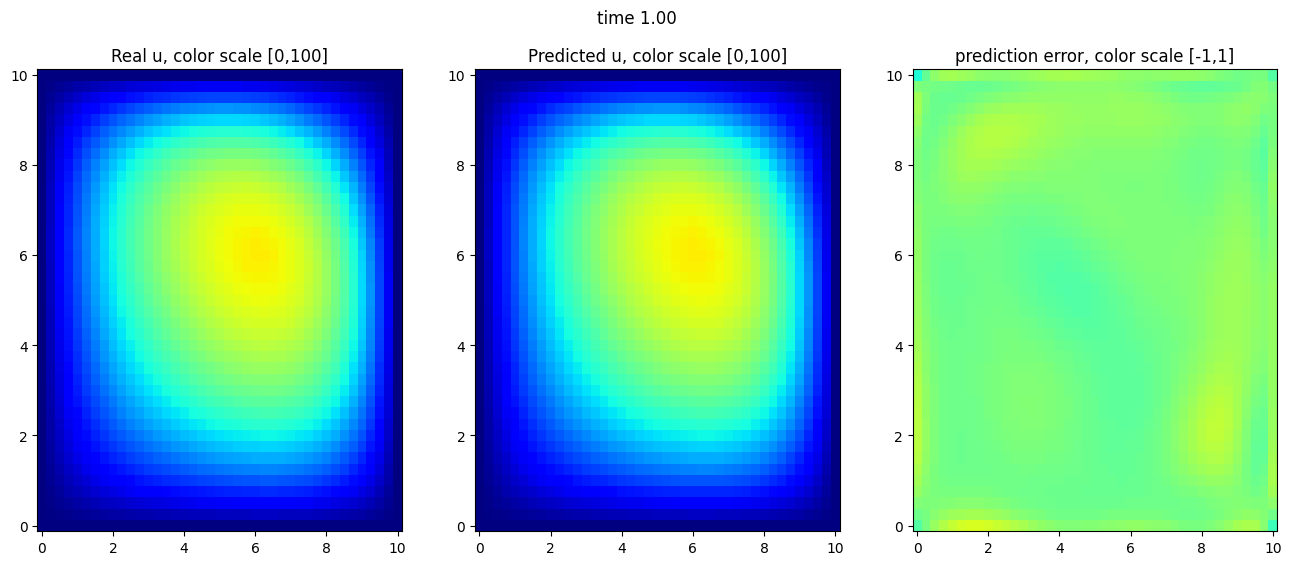

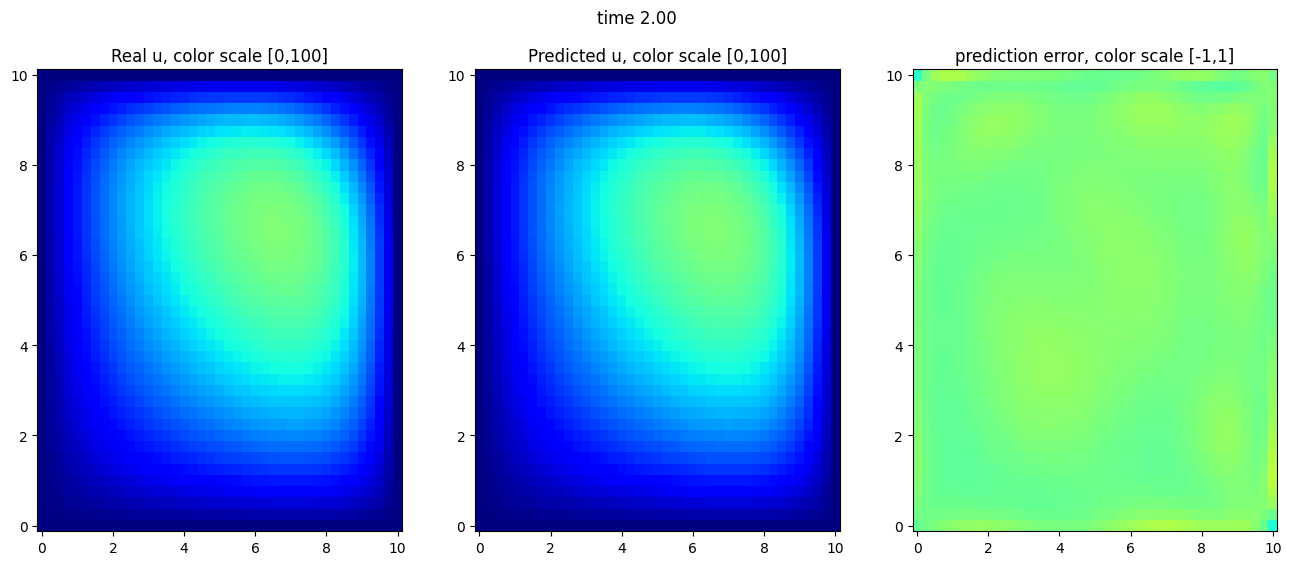

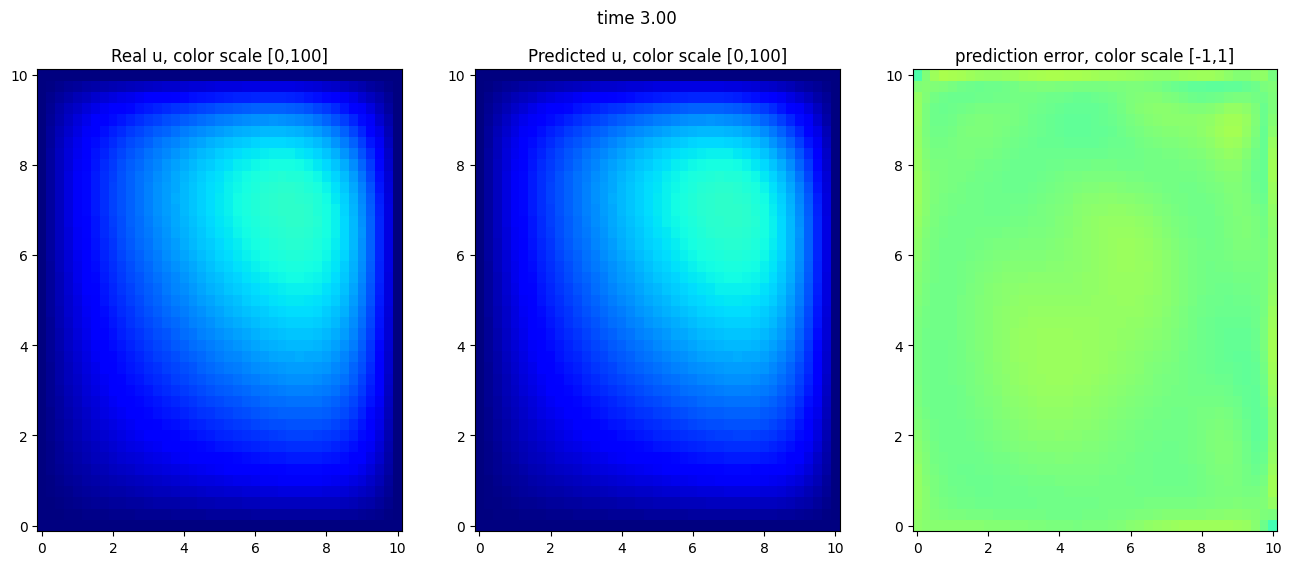

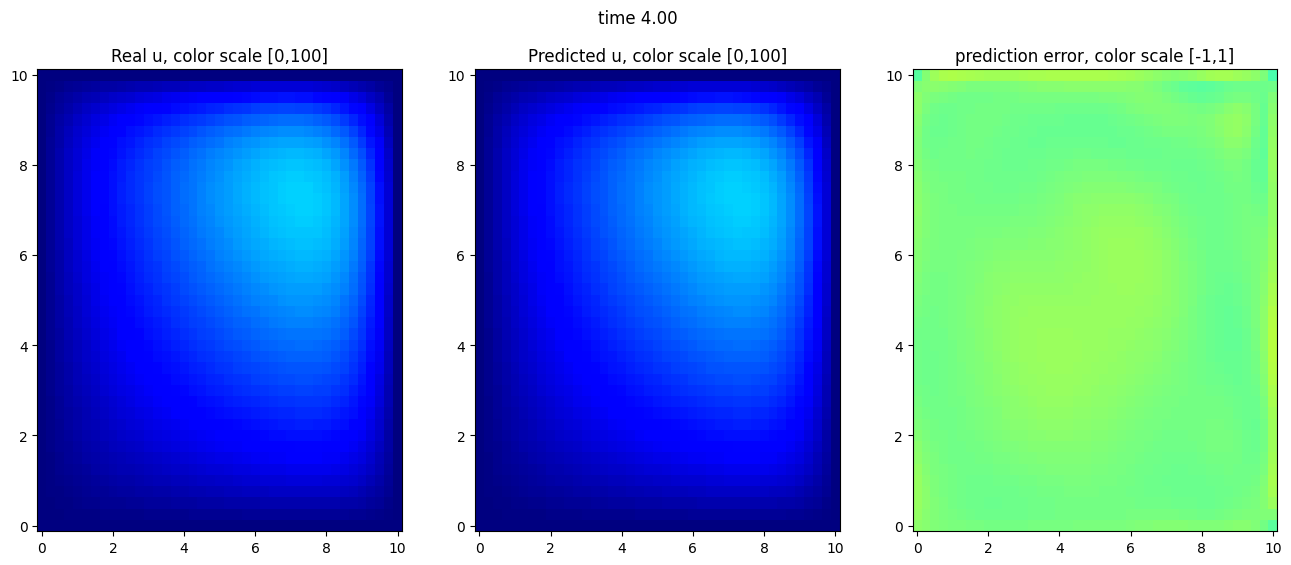

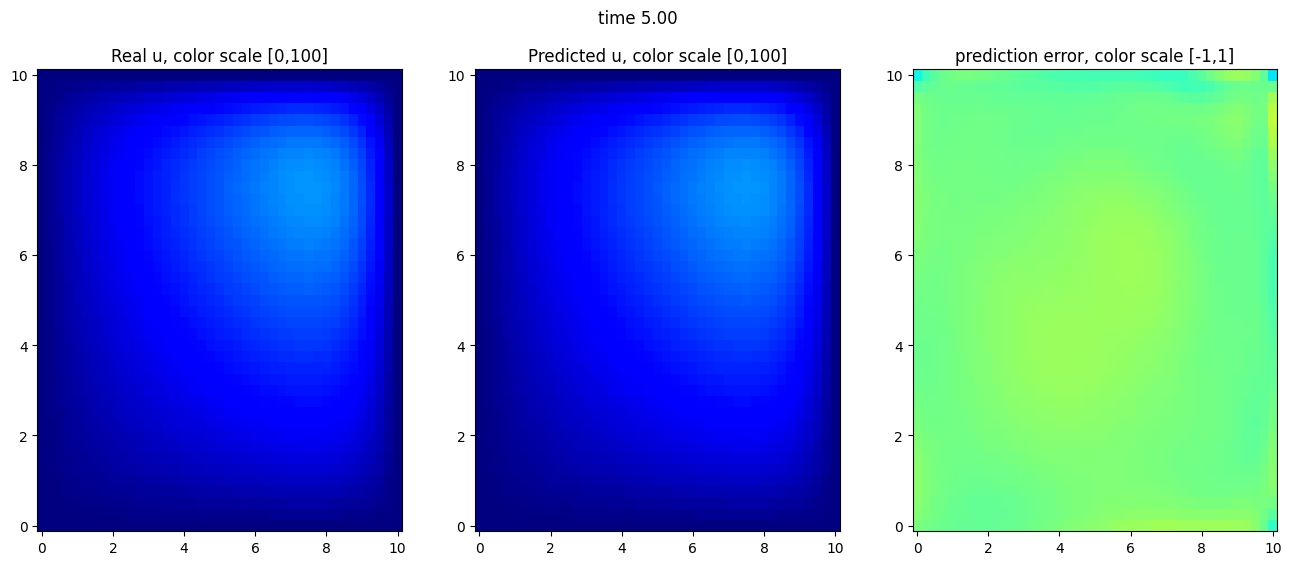

In [ ]:
for t in t_snapshots:
  xy_batch = torch.stack(
    (
      torch.tensor(X.flatten()),
      torch.tensor(Y.flatten()),
    ),
    dim=1
    ).float().unsqueeze(0).to(device)
  t_batch = torch.full((1,X.size,1), t).to(device)
  with torch.no_grad():
    u_pred = model_u(xy_batch, t_batch).cpu().numpy()[0,:,0].reshape(X.shape)

  snapshot_data = solution_data_all[solution_data_all[:,0]==t]
  u_gt = snapshot_data[data_order,3].reshape(X.shape)
  fig, axs= plt.subplots(ncols=3, figsize=(16,6))
  axs[0].pcolormesh(X, Y, u_gt, vmin=0, vmax=100, cmap='jet')
  axs[0].set_title('Real u, color scale [0,100]')
  axs[1].pcolormesh(X, Y, u_pred, vmin=0, vmax=100, cmap='jet')
  axs[1].set_title('Predicted u, color scale [0,100]')
  axs[2].pcolormesh(X, Y, u_pred - u_gt, vmin=-1, vmax=1, cmap='jet')
  axs[2].set_title('prediction error, color scale [-1,1]')
  fig.suptitle(f'time {t:0.2f}')




## What next?



### Space interpolation/extrapolation

- cut out some space from training data, eg. $x \in [...], y \in [...]$
- use collocation points form full space
- evaluate $D(x,y)$ and $u(x,y,t)$ on unseen space and data points, respectively

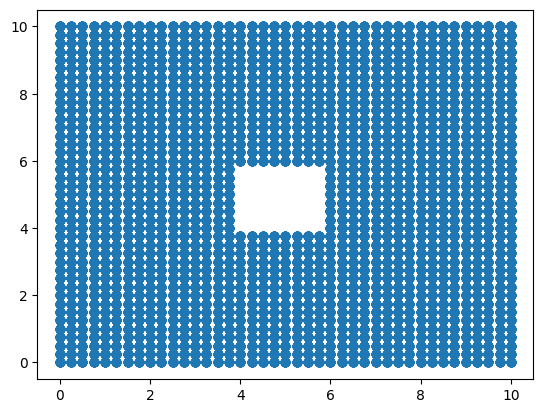

In [ ]:
#masked data: (x>x_min) & (x<x_max) &
x_cut_min, x_cut_max = 4, 6
y_cut_min, y_cut_max = 4, 6
cutout_mask = (solution_data_all[:,1] >=x_cut_min) & (solution_data_all[:,1] < x_cut_max) & (solution_data_all[:,2] >=y_cut_min) & (solution_data_all[:,2] < y_cut_max)
solution_data_masked = solution_data_all[~cutout_mask]

solution_data = solution_data_masked[np.random.choice(len(solution_data_masked), num_of_data, replace=False), :].astype(np.float32)
plt.scatter(solution_data[:,1], solution_data[:,2])

### Time extrapolation

- Limit training data to $t \in [0,2]$
- Use collocationp points from full $t \in [0,5]$ range
- evaluate $u(x,y,t)$ for unseed data $t \in [4,5]$


In [ ]:
t_min = 0
t_max = 2

cutout_mask = (solution_data_all[:,0] <t_min) | (solution_data_all[:,0] >= t_max)
solution_data_masked = solution_data_all[~cutout_mask]
print(len(solution_data_masked))

solution_data = solution_data_masked[np.random.choice(len(solution_data_masked), min(num_of_data, len(solution_data_masked)), replace=False), :].astype(np.float32)


33620


### Try different loss weights

when you loose accuracy?

### Network architectures

- larger network
- does it work with ReLU?
